# Technique about DeepLearning

In [3]:
import numpy as np

### 1, SGD(stochastic gradient descent)

$$
W \leftarrow W - \eta \frac{\sigma L}{\sigma W}
$$

This mean to update the value on the left side with the value on the right side

In [4]:
class SGD:
    def __init__(self, lr=0.01): # lr: Learning rate
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

### 2, Momentum

$$
v \leftarrow \alpha v - \eta \frac{\sigma L}{\sigma W}
$$

$$
W \leftarrow W + v
$$

In [5]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9): # momentum: Deserves alpha in the above formula
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def __update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)

        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * grads[key]
            params[key] += self.v[key]

### 3, AdaGrad

$$
h \leftarrow h + \frac{\sigma L}{\sigma W} \times \frac{\sigma L}{\sigma W}
$$

$$
W \leftarrow W - \eta \frac{1}{\sqrt{h}} \frac{\sigma L}{\sigma W}
$$

In [ ]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

Another one, There is also a method called Adam \
It is a new method which combined AdaGrad and Momentum

### 4, Execute optimizer each other

In [1]:
import sys, os
sys.path.append(os.pardir)
import matplotlib.pyplot as plt
from collections import OrderedDict
from shared_code.optimizer import *

In [2]:
def f(x, y):
    return x**2 / 20.0 + y**2

def df(x, y):
    return x / 10.0, 2.0*y

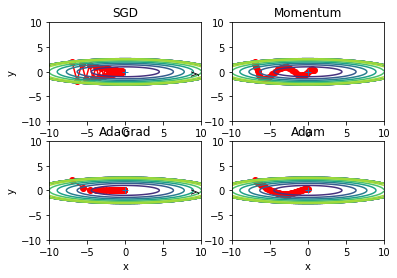

In [3]:
init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

# Add a optimizers dictionary
optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]

    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])

        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)

    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)

    # for simple contour line
    mask = Z > 7
    Z[mask] = 0

    # plot
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color='red')
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    # colorbar()
    # sprint()
    plt.title(key)
    plt.xlabel('x')
    plt.ylabel('y')

plt.show()


### 5, Initial value of weight

#### 5-1, Weight init activation histogram

In [2]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from shared_code.functions import sigmoid

In [7]:
x = np.random.randn(1000, 100) # 1000 data

node_num = 100 # A number of hidden layer node
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    # w = np.random.randn(node_num, node_num) * 1 # gradient vanishing
    w = np.random.randn(node_num, node_num) * 0.01

    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

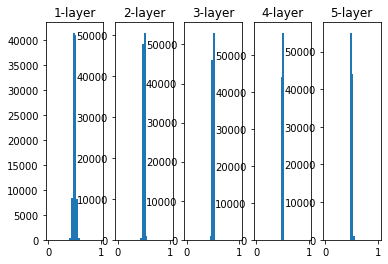

In [8]:
# draw a histogram
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

In [9]:
# initial value of Xavier

x = np.random.randn(1000, 100)

node_num = 100 # A number of hidden layer node
hidden_layer_size = 5
activations = {}

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i - 1]

    # w = np.random.randn(node_num, node_num) * 1 # gradient vanishing
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)

    z = np.dot(x, w)
    a = sigmoid(z)
    activations[i] = a

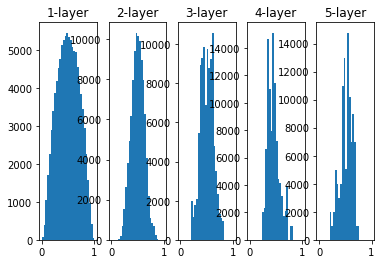

In [10]:
# draw a histogram
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0, 1))
plt.show()

#### 5-2, Initial value of He

It is usually using ReLu activation functions. \

Comparison of other initial weight values

In [1]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
from chapter3.dataset.mnist import load_mnist
from shared_code.util import smooth_curve
from shared_code.multi_layer_net import MultiLayerNet
from shared_code.optimizer import SGD

In [2]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

# Experiment settings
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                                output_size=10, weight_init_std=weight_type)
    train_loss[key] = []

# Start training
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    if i % 100 == 0:
        print(f"======= iteration: {str(i)} =======")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(f"{key} : {str(loss)}")

# Draw graph
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

AttributeError: 'collections.OrderedDict' object has no attribute 'vlaues'